In [1]:
from __future__ import annotations
import operator
from typing import TypedDict, List, Annotated
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

True

In [2]:
class Task(BaseModel):
    id: int
    title: str
    brief: str = Field(..., description="What to cover")

In [3]:
class Plan(BaseModel):
    blog_title: str
    tasks: List[Task]

In [4]:
class State(TypedDict):
    topic: str
    plan: Plan
    # reducer: results from workers get concatenated automatically
    sections: Annotated[List[str], operator.add]
    final: str

In [5]:
llm = ChatGroq(model="openai/gpt-oss-120b")

In [6]:
def orchestrator(state: State) -> dict:

    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content=(
                    "Create a blog plan with 5-7 sections on the following topic."
                )
            ),
            HumanMessage(content=f"Topic: {state['topic']}"),
        ]
    )
    return {"plan": plan}

In [7]:
def fanout(state: State):
    return [Send("worker", {"task": task, "topic": state["topic"], "plan": state["plan"]})
            for task in state["plan"].tasks]

In [8]:
def worker(payload: dict) -> dict:

    # payload contains what we sent
    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]

    blog_title = plan.blog_title

    section_md = llm.invoke(
        [
            SystemMessage(content="Write one clean Markdown section."),
            HumanMessage(
                content=(
                    f"Blog: {blog_title}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Brief: {task.brief}\n\n"
                    "Return only the section content in Markdown."
                )
            ),
        ]
    ).content.strip()

    return {"sections": [section_md]}

In [9]:
def reducer(state: State) -> dict:

    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()
    
    final_md = f"# {title}\n\n{body}\n"

    # Save to file
    filename = "".join(c if c.isalnum() or c in (" ", "_", "-") else "" for c in title)
    filename = filename.strip().lower().replace(" ", "_") + ".md"
    Path(filename).write_text(final_md, encoding="utf-8")

    return {"final": final_md}

In [11]:
graph = StateGraph(State)
graph.add_node("orchestrator", orchestrator)
graph.add_node("worker", worker)
graph.add_node("reducer", reducer)

graph.add_edge(START, "orchestrator")
graph.add_conditional_edges("orchestrator", fanout, ["worker"])
graph.add_edge("worker", "reducer")
graph.add_edge("reducer", END)

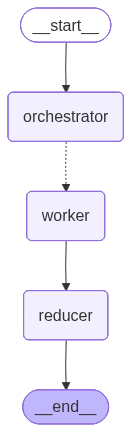

In [12]:
app = graph.compile()
app

In [13]:
out = app.invoke({"topic": "Write a blog on Self Attention", "sections": []})

In [14]:
print(out["final"])

# Demystifying Self-Attention: The Engine Behind Modern NLP

## Introduction to Attention Mechanisms

In the early days of neural language models, **sequential processing** was the dominant paradigm. Recurrent networks (RNNs, LSTMs, GRUs) read a sentence token‑by‑token, compressing all prior information into a single hidden state. While powerful, this approach suffered from two fundamental drawbacks:

1. **Information bottleneck** – a fixed‑size vector must encode everything the model has seen, making it hard to retain long‑range dependencies.  
2. **Uniform treatment of context** – each token contributes equally to the hidden state, even though some words (e.g., “not”, proper nouns, or domain‑specific terms) are far more informative for a given prediction.

### The Birth of Attention

The first breakthrough came in 2014–2015 with the **Bahdanau et al. (2015)** and **Luong et al. (2015)** papers on *neural machine translation*. Their key insight: rather than forcing the decoder to rely